# Sentiment Analysis for Steam Reviews
Steam is a video game digital distribution service with a vast community of gamers globally. A lot of gamers write reviews at the game page and have an option of choosing whether they would recommend this game to others or not. However, determining this sentiment automatically from text can help Steam to automatically tag such reviews extracted from other forums across the internet and can help them better judge the popularity of games.

Given the review text with user recommendation and other information related to each game for 64 game titles, the task is to predict whether the reviewer recommended the game titles available in the test set on the basis of review text and other information.

Game overview information for both train and test are available in single file game_overview.csv inside train.zip



In [0]:
import pandas as pd
import numpy as np
import unicodedata  
from nltk import sent_tokenize
from nltk.corpus import stopwords
import nltk
import re
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer


In [0]:
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)

In [0]:
train = pd.read_csv('train_E52nqFa/train.csv')
game = pd.read_csv('train_E52nqFa/game_overview.csv')
test = pd.read_csv('test_BppAoe0/test.csv')

Exploring the train data

In [0]:
train.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


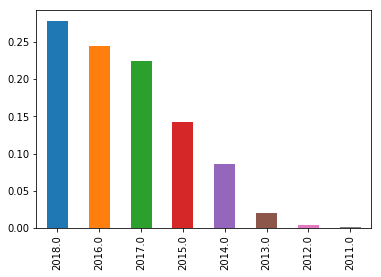

In [0]:
train['year'].value_counts(normalize=True).plot(kind='bar')

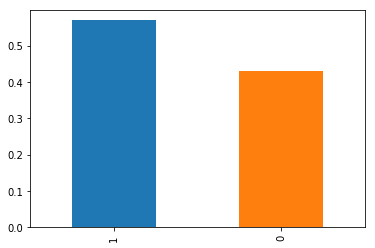

In [0]:
train['user_suggestion'].value_counts(normalize=True).plot(kind='bar')

From the columns it is explicit that review id is unique for each post,
title of the game to be used as foreign key between the two tables, data set has 60% of negative class and 40% of positive class. Data comprises of review of the games released in this decade (2011-2018), having most of the reviews about the game in 2018,2016 and 2017


In [0]:
train['user_suggestion'].value_counts()

1    9968
0    7526
Name: user_suggestion, dtype: int64

In [0]:
train[train['user_suggestion']==0]['title'].value_counts(normalize=True).head(5)

Robocraft                 0.105501
Heroes & Generals         0.088095
War Thunder               0.079458
Bless Online              0.074542
Infestation: The New Z    0.046505
Name: title, dtype: float64

In [0]:
train[train['user_suggestion']==1]['title'].value_counts().head(5)

Fractured Space      688
Eternal Card Game    495
Creativerse          443
PlanetSide 2         423
Path of Exile        415
Name: title, dtype: int64

In [0]:
mylist = []
for tag in game['tags']:
    mylist.extend(tag)

mylist = [x.lower().strip() for x in mylist]

uniquevalues = list(set(mylist))

In [0]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        new_word = re.sub(r'(.)\1+', r'\1\1', new_word) 
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    stop_words = []
    stop_words.append(stopwords.words('english'))
    stop_words.append(uniquevalues)
    for word in words:
        if(word not in stop_words):
            new_words.append(word)
    return new_words

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

# def replace_contractions(text):
#     """Replace contractions in string of text"""
#     return contractions.fix(text)


In [0]:
def preprocess(text):
    # text = replace_contractions(text)
    content = nltk.word_tokenize(text)
    words = remove_non_ascii(content)
    words = to_lowercase(words)
    words = lemmatize_verbs(words)
    words = remove_punctuation(words)
    # words = remove_stopwords(words)
    # text= ' '.join(list(dict.fromkeys(words)))
    text = ' '.join(words)
    return text

def preprocess2(text):
    # text = replace_contractions(text)    
    content = nltk.word_tokenize(text)
    words = remove_non_ascii(content)
    words = to_lowercase(words)
    words = remove_stopwords(words)
    words = lemmatize_verbs(words)
    words = remove_punctuation(words)
    
    # text= ' '.join(list(dict.fromkeys(words)))
    text = ' '.join(words)
    return text

def join_tags(words):
    text = ''.join(words)
    return text


In [0]:
train['title'] = train['title'].apply(preprocess)
game['title'] = game['title'].apply(preprocess)
test['title'] = test['title'].apply(preprocess)

game['tags'] = game['tags'].apply(preprocess)
game['overview'] = game['overview'].apply(preprocess)

In [0]:
train['new_user_review'] = train['user_review'].apply(preprocess2)
test['new_user_review'] = test['user_review'].apply(preprocess2)

In [0]:
test.shape

(8045, 5)

In [0]:
train['new_user_review'].replace({'':np.nan}, inplace=True)
train = train[~train['new_user_review'].isna()]

In [0]:
# to remove the reviews when the no of words is equivalent to 1
train['no_of_words'] = train['new_user_review'].apply(lambda x: len(x.split()))
test['no_of_words'] = test['new_user_review'].apply(lambda x: len(x.split()))

In [0]:
train['year'] = train.groupby(['title'])['year'].fillna(method='ffill').fillna(method='bfill')

In [0]:
test.shape

(8045, 6)

maximum length of reviews is 1600 and we can clearly see that most of the posts are short in length

## Wordcloud just to observe which is the most frequent word

In [0]:
def plot_wordcloud(train, sent, col):
    reviews = train[train['user_suggestion']==sent][col].str.cat(sep=' ')
    #function to split text into word
    tokens = word_tokenize(reviews)
    vocabulary = set(tokens)
    frequency_dist = nltk.FreqDist(tokens)
    wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

wordcloud of the positive reviews

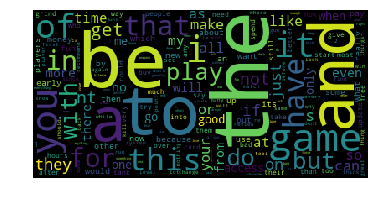

In [0]:
plot_wordcloud(train, 0, 'new_user_review')

word cloud of negative reviews

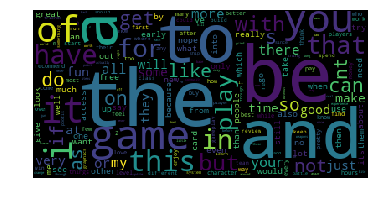

In [0]:
plot_wordcloud(train, 1, 'new_user_review')

## Merging the train and test with game information

In [0]:
train_df = pd.merge(train, game, left_on = ['title'], right_on= ['title'])
test_df = pd.merge(test, game, on=['title'], how='inner')

In [0]:
test_df.shape

(8045, 10)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
x_train, x_valid, y_train, y_valid = train_test_split(train_df, train_df['user_suggestion'], 
                                                      random_state=0,test_size=0.15, stratify=train_df['user_suggestion'])

### Probability of positive response for the particular game

In [0]:
x_train.columns

Index(['review_id', 'title', 'year', 'user_review', 'user_suggestion',
       'new_user_review', 'no_of_words', 'developer', 'publisher', 'tags',
       'overview'],
      dtype='object')

In [0]:
probability = x_train.groupby(['title','user_suggestion']).agg({'new_user_review':'count'}).reset_index()

In [0]:
probability['total_reviews'] = probability.groupby(['title'])['new_user_review'].transform('sum')

In [0]:
probability2 = pd.pivot_table(probability, index=['title','total_reviews'], columns=['user_suggestion'], values=['new_user_review']).reset_index()

In [0]:
probability2.columns = ['title','total_reviews','probab_rec','probab_no_rec']

In [0]:
probability2['probab_no_rec'] = probability2['probab_no_rec']/probability2['total_reviews']
probability2['probab_rec'] = probability2['probab_rec']/probability2['total_reviews']

In [0]:
train_df['is_train'] = 1
test_df['is_train'] = 0

In [0]:
test_df.shape

(8045, 11)

In [0]:
df = pd.concat([train_df, test_df], axis=0)

C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [0]:
df.shape

(25517, 12)

In [0]:
df[df['is_train'] == 0].shape

(8045, 12)

In [0]:
df = pd.merge(df, probability2[['probab_rec','probab_no_rec','title']], on='title', how='left')

In [0]:
df.shape

(25517, 14)

### probability of response based on the year

In [0]:
probability = x_train.groupby(['user_suggestion','year']).agg({'new_user_review':'count'}).reset_index()
probability['total_review'] = probability.groupby(['year'])['new_user_review'].transform('sum')

In [0]:
probability2 = pd.pivot_table(probability, index=['year','total_review'], values='new_user_review', columns='user_suggestion').reset_index()

In [0]:
probability2.columns = ['year','total_reviews','year_rec','year_no_rec']

In [0]:
probability2['year_rec'] = probability2['year_rec']/probability2['total_reviews']
probability2['year_no_rec'] = probability2['year_no_rec']/probability2['total_reviews']

In [0]:
df = pd.merge(df, probability2[['year_rec','year_no_rec','year']], on='year',how='left')

In [0]:
df.shape

(25517, 16)

### Additional features based on the user review

In [0]:
# creating the python dictionary to hold the lexicons
import collections
import csv
lexicon = collections.defaultdict(list)

with open('new_lexicon.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        lexicon[row[0]].append(int(row[1]))
        lexicon[row[0]].append(row[2])
csvFile.close()   

In [0]:
#number of negative words in a tweet
def neg_word_count(tweet):
    count = 0
    for i in tweet.split():
        #print(i)
        if i in lexicon:
            #print(i)
            try: 
                score = lexicon[i][0]
                #print('score',score)
                if score == -1:
                    count+=1            
            except: pass
    return count


#no of positive words in a tweet
def pos_word_count(tweet):
    count = 0
    for i in tweet.split():
        #print(i)
        if i in lexicon:
            #print(i)
            try: 
                score = lexicon[i][0]
                #print('score',score)
                if score == 1:
                    count+=1            
            except: pass
    return count

#overall score of the tweet
def overall_score(tweet):
    score = 0
    for i in tweet.split():
        if i in lexicon:
            try:
                a = lexicon[i][0]
                score += a
            except: 
                pass
    return score

#last token polarity
def las_pol(tweet):
    # print(tweet)
    tweet = tweet.split()
    l_word = tweet[-1]
    score = 0
    if l_word in lexicon:
        a = lexicon[l_word][0]
        #print(a)
        score = a
        #print(score)
    return score

#number of adjectives, adverbs and verbs in a tweet
def pos_POStag_count(tweet):
    count = 0
    l = ['adj','adverb','verb']
    for i in tweet.split():
        if i in lexicon:
            #print(i)
            try:
                pos_tag = lexicon[i][1]
                if pos_tag in l:
                    #print(lexicon[i])
                    if lexicon[i][0] == 1:
                        count+=1

            except: 
                pass
    return count  

#number of adjectives, adverbs and verbs in a tweet
def neg_POStag_count(tweet):
    count = 0
    l = ['adj','adverb','verb']
    for i in tweet.split():
        if i in lexicon:
            #print(i)
            try:
                pos_tag = lexicon[i][1]
                if pos_tag in l:
                    #print(lexicon[i])
                    if lexicon[i][0] == -1:
                        count+=1

            except: 
                pass
    return count  

In [0]:
df['new_user_review'].replace({'':'good bad'}, inplace=True)
#df = df[~df['new_user_review'].isna()]

In [0]:
df.shape

(25517, 16)

In [0]:
df['last_word_polarity'] = df['new_user_review'].apply(las_pol)#run this after preprocessing
#number of pos tagging do after preprocessing of the tweets
df['pos_POStag_count'] = df['new_user_review'].apply(pos_POStag_count)
df['neg_POStag_count'] = df['new_user_review'].apply(neg_POStag_count)
df['neg_count'] = df['new_user_review'].apply(neg_word_count)
#number of positive word count
df['pos_count']= df['new_user_review'].apply(pos_word_count)
df['overall_score'] = df['new_user_review'].apply(overall_score)

In [0]:
train_df = df[df['is_train']==1]
test_df = df[df['is_train']==0]

In [0]:
test_df.shape

(8045, 22)

## label encoding the developer and title

In [0]:
from sklearn.preprocessing import LabelEncoder

class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)


In [0]:
le = LabelEncoderExt()
le.fit(train_df['developer'])
train_df['developer'] = le.transform(train_df['developer'])
test_df['developer'] = le.transform(test_df['developer'])

C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
le = LabelEncoderExt()
le.fit(train_df['title'])
train_df['title'] = le.transform(train_df['title'])
test_df['title'] = le.transform(test_df['title'])

C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
train_df.drop(['review_id','user_review','publisher','is_train'], axis=1, inplace=True)

C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## creating PIPELINE with additional features

In [0]:
train_df.columns

Index(['developer', 'new_user_review', 'no_of_words', 'overview', 'tags',
       'title', 'user_suggestion', 'year', 'probab_rec', 'probab_no_rec',
       'year_rec', 'year_no_rec', 'last_word_polarity', 'pos_POStag_count',
       'neg_POStag_count', 'neg_count', 'pos_count', 'overall_score'],
      dtype='object')

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None): # fit() doesn't do anything
        return self

    def transform(self, X):   # all the work is done here
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]


In [0]:
# 'title', 'year', 'user_suggestion', 'new_user_review', 'no_of_words',
#        'developer', 'tags', 'overview', 'is_train', 'probab_rec',
#        'probab_no_rec', 'year_rec', 'year_no_rec', 'last_word_polarity',
#        'pos_POStag_count', 'neg_POStag_count', 'neg_count', 'pos_count',
#        'overall_score'

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

review_tag = Pipeline([
                ('selector', TextSelector(key='review_tag')),
                ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',ngram_range=(1,2)))
            ])

# tags = Pipeline([
#                 ('selector', TextSelector(key='tags')),
#                 ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}'))
#             ])

no_of_words =  Pipeline([
                ('selector', NumberSelector(key='no_of_words')),
                ('standard', MinMaxScaler())
            ])

year =  Pipeline([
                ('selector', NumberSelector(key='year'))
            ])
developer =  Pipeline([
                ('selector', NumberSelector(key='developer'))
            ])
title =  Pipeline([
                ('selector', NumberSelector(key='title'))
            ])

probab_rec =  Pipeline([
                ('selector', NumberSelector(key='probab_rec'))
            ])

probab_no_rec =  Pipeline([
                ('selector', NumberSelector(key='probab_no_rec'))
            ])

year_rec =  Pipeline([
                ('selector', NumberSelector(key='year_rec'))
            ])

year_no_rec =  Pipeline([
                ('selector', NumberSelector(key='year_no_rec'))
            ])

pos_POStag_count =  Pipeline([
                ('selector', NumberSelector(key='pos_POStag_count')),
                ('standard', MinMaxScaler())
            ])
neg_POStag_count =  Pipeline([
                ('selector', NumberSelector(key='neg_POStag_count')),
                ('standard', MinMaxScaler())
            ])

neg_count =  Pipeline([
                ('selector', NumberSelector(key='neg_count')),
                ('standard', MinMaxScaler())
            ])
pos_count =  Pipeline([
                ('selector', NumberSelector(key='pos_count')),
                ('standard', MinMaxScaler())
            ])
overall_score =  Pipeline([
                ('selector', NumberSelector(key='overall_score')),
                ('standard', MinMaxScaler())
            ])
last_word_polarity =  Pipeline([
                ('selector', NumberSelector(key='last_word_polarity')),
                ('standard', MinMaxScaler())
            ])

In [0]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion([('review_tag', review_tag), 
                      # ('tags', tags),
                      ('no_of_words', no_of_words),
                      ('title',title),
                      ('developer',developer),
                      ('year',year),
                      ('probab_rec',probab_rec),
                      ('probab_no_rec',probab_no_rec),
                      ('year_rec',year_rec),
                      ('year_no_rec',year_no_rec),
                      ('neg_count', neg_count),
                      ('pos_count', pos_count),
                      ('overall_score', overall_score),
                      ('last_word_polarity', last_word_polarity),
                      ('pos_POStag_count', pos_POStag_count),
                      ('neg_POStag_count', neg_POStag_count)])

feature_processing = Pipeline([('feats', feats)])

### word cloud of the tags used in negative class


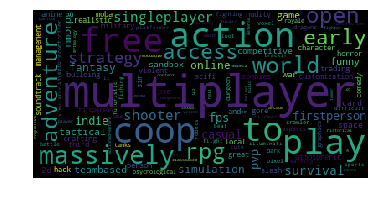

In [0]:
plot_wordcloud(df, 1, 'tags')

Tags used in positive review


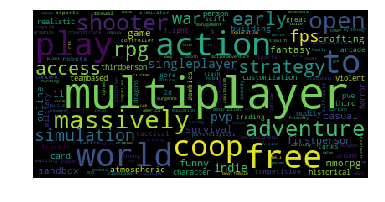

In [0]:
plot_wordcloud(df, 0, 'tags')

## SPLITTING TRAINING AND TEST

In [0]:
train_df2 = train_df[(train_df['no_of_words']>1)]

In [0]:
train_df2['review_tag'] = train_df2['new_user_review']+train_df2['tags']
test_df['review_tag']= test_df['new_user_review']+test_df['tags']

C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
x_train, x_valid, y_train, y_valid = train_test_split(train_df2, train_df2['user_suggestion'], 
                                                      random_state=0,test_size=0.15, stratify=train_df2['user_suggestion'])

In [0]:
x_train = x_train.fillna(0)
x_valid = x_valid.fillna(0)

In [0]:
print(y_train.shape)

(14836,)


### ML model with additional features

In [0]:
feature_processing.fit_transform(x_train) 
feature_processing.transform(x_valid) 
feature_processing.transform(test_df) 

<8045x582325 sparse matrix of type '<class 'numpy.float64'>'
	with 1837841 stored elements in Compressed Sparse Row format>

In [0]:
from collections import Counter
Counter(y_train)

Counter({1.0: 8448, 0.0: 6388})

In [0]:
import numpy as np
from sklearn import svm
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(objective='binary:logistic')),
    # ('classifier', RandomForestClassifier())
])

C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [0]:
pipeline.fit(x_train, y_train, )

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('review_tag', Pipeline(memory=None,
     steps=[('selector', TextSelector(key='review_tag')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', in...ale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None))])

In [0]:
y_pred = pipeline.predict_proba(x_valid)
test_pred = pipeline.predict_proba(test_df)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

def evaluate_model(y_true, y_pred):
    print('confusion matrix')
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm.T)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print(cm_df)
    print('classification report')
    print(classification_report(y_true,y_pred))
    print('accuracy score')
    print(accuracy_score(y_true, y_pred))

In [0]:
type(y_valid)

pandas.core.series.Series

In [0]:
s = np.argmax(y_pred,axis=1)

In [0]:
s= pd.Series(s)

In [0]:
y_pred1 = s

In [0]:
y_pred1.shape

(2619,)

In [0]:
y_pred.shape

(2619, 2)

In [0]:
y_valid.shape

(2619,)

In [0]:
evaluate_model(y_valid, y_pred1)

confusion matrix
True         0     1
Predicted           
0          918   167
1          210  1324
classification report
             precision    recall  f1-score   support

        0.0       0.85      0.81      0.83      1128
        1.0       0.86      0.89      0.88      1491

avg / total       0.86      0.86      0.86      2619

accuracy score
0.8560519282168767



randomised search of XGboost

In [0]:
test_df['user_suggestion'] = np.argmax(test_pred, axis=1)

C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
test_df.shape

(8045, 23)

In [0]:
submission_xgb = test_df[['review_id','user_suggestion']]
submission_xgb.to_csv("submission_sh_v1.csv",index=False)

# Machine learning model (BASELINE)

In [0]:
feats = FeatureUnion([('review_tag', review_tag), 
                      # ('tags', tags),
                      ('neg_count', neg_count),
                      ('pos_count', pos_count),
                      ('overall_score', overall_score),
                      ('last_word_polarity', last_word_polarity),
                      ('pos_POStag_count', pos_POStag_count),
                      ('neg_POStag_count', neg_POStag_count)])

feature_processing = Pipeline([('feats', feats)])

In [0]:
train_df2 = train_df[(train_df['no_of_words']>1)]

train_df2['review_tag'] = train_df2['new_user_review']+train_df2['tags']
test_df['review_tag']= test_df['new_user_review']+test_df['tags']

x_train, x_valid, y_train, y_valid = train_test_split(train_df2, train_df2['user_suggestion'], 
                                                      random_state=0,test_size=0.15, stratify=train_df2['user_suggestion'])

x_train = x_train.fillna(0)
x_valid = x_valid.fillna(0)

print(y_train.shape)

### ML model with additional features

feature_processing.fit_transform(x_train) 
feature_processing.transform(x_valid) 
feature_processing.transform(test_df) 

C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(14836,)


<8045x582317 sparse matrix of type '<class 'numpy.float64'>'
	with 1781528 stored elements in Compressed Sparse Row format>

In [0]:
pipeline_svm = Pipeline([
    ('features',feats),
    ('classifier', svm.SVC(C=100, class_weight='balanced',gamma = 1e-4, kernel='linear'))])

pipeline_svm.fit(x_train, y_train )

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('review_tag', Pipeline(memory=None,
     steps=[('selector', TextSelector(key='review_tag')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', in...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [0]:
y_pred = pipeline_svm.predict(x_valid)
test_pred = pipeline_svm.predict(test_df)

In [0]:
test_pred.shape

(8045,)

In [0]:
evaluate_model(y_valid, y_pred)

confusion matrix
True         0     1
Predicted           
0          971   139
1          157  1352
classification report
             precision    recall  f1-score   support

        0.0       0.87      0.86      0.87      1128
        1.0       0.90      0.91      0.90      1491

avg / total       0.89      0.89      0.89      2619

accuracy score
0.8869797632684231


In [0]:
test_df['user_suggestion'] = test_pred.astype(int)

test_df.shape



C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(8045, 23)

In [0]:
submission_svm = test_df[['review_id','user_suggestion']]
submission_svm.to_csv("submission_sh_v2_svm.csv",index=False)

In [0]:
## Random forest

feats = FeatureUnion([('review_tag', review_tag), 
                      # ('tags', tags),
                      ('no_of_words', no_of_words),
                      ('title',title),
                      ('developer',developer),
#                       ('year',year),
#                       ('probab_rec',probab_rec),
#                       ('probab_no_rec',probab_no_rec),
#                       ('year_rec',year_rec),
#                       ('year_no_rec',year_no_rec),
                      ('neg_count', neg_count),
                      ('pos_count', pos_count),
                      ('overall_score', overall_score),
                      ('last_word_polarity', last_word_polarity),
                      ('pos_POStag_count', pos_POStag_count),
                      ('neg_POStag_count', neg_POStag_count)])

feature_processing = Pipeline([('feats', feats)])

In [0]:
pipeline_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=100))])

pipeline_rf.fit(x_train, y_train )

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('review_tag', Pipeline(memory=None,
     steps=[('selector', TextSelector(key='review_tag')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', in...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [0]:
y_pred = pipeline_rf.predict(x_valid)
test_df1 = test_df.replace(np.nan,0)
test_pred = pipeline_rf.predict(test_df1)

test_pred.shape

evaluate_model(y_valid, y_pred)

confusion matrix
True         0     1
Predicted           
0          780   153
1          348  1338
classification report
             precision    recall  f1-score   support

        0.0       0.84      0.69      0.76      1128
        1.0       0.79      0.90      0.84      1491

avg / total       0.81      0.81      0.81      2619

accuracy score
0.8087056128293242


In [0]:
test_df['user_suggestion'] = test_pred.astype(int)

test_df.shape



submission_rf = test_df[['review_id','user_suggestion']]
submission_rf.to_csv("submission_sh_v3_rf.csv",index=False)

C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## BERT

In [0]:
from bert_serving.client import BertClient

# make a connection with the BERT server using it's ip address
bc = BertClient()
# get the embedding for train and val sets

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

count_vec = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1))
                           # max_df=0.25, binary=True, norm='l2')

In [0]:
xtrain_count = count_vec.fit_transform(x_train['review_tag'])
xvalid_count = count_vec.transform(x_valid['review_tag'])

In [0]:
print(xtrain_count.shape)
print(xvalid_count.shape)

(14836, 67165)
(2619, 67165)


In [0]:
from sklearn import svm
classifier_svm = svm.SVC(C=100, class_weight='balanced',\
                         gamma = 1e-4, kernel='linear' )

In [0]:
classifier_svm.fit(xtrain_count, y_train)
svm_predictions = classifier_svm.predict(xvalid_count)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
accuracy_score(y_valid, svm_predictions)

0.5693012600229095

In [0]:
import pandas as pd
cm = confusion_matrix(y_valid, svm_predictions)
cm_df = pd.DataFrame(cm.T)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True          0     1
Predicted            
0             0     0
1          1128  1491


In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
accuracy_score(y_valid, svm_predictions)

0.5693012600229095

In [0]:
import pandas as pd
cm = confusion_matrix(y_valid, svm_predictions)
cm_df = pd.DataFrame(cm.T)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True          0     1
Predicted            
0             0     0
1          1128  1491


In [0]:
print(classification_report(y_valid,svm_predictions))

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00      1128
        1.0       0.57      1.00      0.73      1491

avg / total       0.32      0.57      0.41      2619



C:\Users\mohan\AppData\Local\Continuum\anaconda2\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


best performance for svm when c 100 ngram (1,1) and class weight is balanced

# TUNING HYPERPARAMETER

In [0]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}')),
    ('clf', RandomForestClassifier(class_weight='balanced'))
])

from sklearn.ensemble import RandomForestClassifier

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

parameters = {
    'vect__max_df': (0.1, 0.25, 0.5, 0.75),
    'vect__binary': (True, False),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'vect__use_idf': (True, False),
    'vect__norm': ('l1', 'l2', None),
    "clf__max_features": max_features,
    'clf__n_estimators': n_estimators,
    'clf__max_depth': max_depth,
    'clf__min_samples_split': min_samples_split,
    'clf__min_samples_leaf': min_samples_leaf,
    'clf__bootstrap': bootstrap
}


In [0]:
rf_random = RandomizedSearchCV(pipeline, parameters, n_jobs=-1, scoring='accuracy', n_iter=100, \
                               cv=5, verbose=2, random_state=42)
rf_random.fit(x_train['review_tag'], y_train)

rf_random.best_score_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 42.7min


In [0]:
params = {"C": [0.5, 1, 10, 100],
    'gamma': [1e-2, 1e-3, 1e-4]}

In [0]:
# from sklearn.model_selection import RandomizedSearchCV
# svm_search = RandomizedSearchCV(svm.SVC(class_weight='balanced'), params, n_jobs=-1, n_iter = 30, verbose=1, scoring='accuracy', cv=5)
# svm_search.fit(xtrain_count, y_train)

In [0]:

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

classifier_RF = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = classifier_RF, param_distributions = random_grid, n_iter = 100 , cv = 10, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(xtrain_count, y_train)

In [0]:
classifier_RF.fit(xtrain_count, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
RF_predictions = classifier_RF.predict(xvalid_count)

In [0]:
print(classification_report(y_valid,RF_predictions))

              precision    recall  f1-score   support

         0.0       0.78      0.65      0.71      1128
         1.0       0.76      0.86      0.81      1490

    accuracy                           0.77      2618
   macro avg       0.77      0.76      0.76      2618
weighted avg       0.77      0.77      0.77      2618



In [0]:
accuracy_score(y_valid, RF_predictions)

0.7696715049656226

In [0]:
new = pd.merge(test,test_df, on = ['review_id'], how='left')

In [0]:
new.fillna(0, inplace=True)

In [0]:
new['user_suggestion'] = new['user_suggestion'].astype('int')

In [0]:

test_df['new_text'] = test_df['new_text'].apply(preprocess)

In [0]:
xtest_count = count_vec.transform(test_df['review_tag'])

In [0]:
test_pred = classifier_svm.predict(xtest_count)

In [0]:
test_df['user_suggestion'] = [int(x) for x in test_pred]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
new[['review_id','user_suggestion']].to_csv('xg_pred.csv', index=False)

using review+tag gives better result instead of using review, tag and overview

## Bert model

In [0]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 40kB 6.4MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=8feb6ff04ff0c50b13400959ebf193c3d98d57bd689ca318c72d4a57d3c52bc7
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=be345e1ab16cc5dbe3d12175597e6f569178783e3bcf19671db0e723a732285e
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.0-cp36-none-any.whl size=15999 sha256=4aa15f368ff9cc8c70672b6053f983f14a8d813a9c4a3b91016f0b5d1453c9d0
  Stored in directory: /root/.cache/pip/wheels/88/41/05/1a9955d1d01575bbd58aab76e22f8c7eeabba905d551576f43
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.0MB 28.4MB/s 


In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import numpy as np
from collections import namedtuple

In [0]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1",trainable=True)

In [0]:
MAX_SEQ_LEN=128
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                    name="segment_ids")

input token ids is tokenizer converts tokens using vocab file.<br>
input masks are either 0 or 1. 1 for useful tokens, 0 for padding.<br>
segment ids are either 0 or 1. For 2 text training: 0 for the first one, 1 for the second one.

MAx sequence length is choosen as 128 based on the available text length in user review

In [0]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))
 
def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [0]:
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [0]:
FullTokenizer=bert.bert_tokenization.FullTokenizer
 
vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()
 
do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()
 
tokenizer=FullTokenizer(vocab_file,do_lower_case)
 
def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [0]:
def create_single_input(sentence,MAX_LEN):
  
  stokens = tokenizer.tokenize(sentence)
  
  stokens = stokens[:MAX_LEN]
  
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)

  return ids,masks,segments

def create_input_array(sentences):

  input_ids, input_masks, input_segments = [], [], []

  for sentence in tqdm(sentences,position=0, leave=True):
  
    ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2)

    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)

  return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

In [0]:
x = tf.keras.layers.Dense(256, activation='relu')(sequence_output)
x = tf.keras.layers.Dropout(0.2)(x)
out = tf.keras.layers.Dense(1, activation="sigmoid", name="dense_output")(x)
 
model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
 
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [0]:
train_sentences = np.array(x_train['new_user_review'])
inputs=create_input_array(train_sentences)


100%|██████████| 14852/14852 [00:16<00:00, 898.05it/s]


In [0]:
valid_sentences = np.array(x_valid['new_user_review'])
val_inputs=create_input_array(valid_sentences)

100%|██████████| 2621/2621 [00:02<00:00, 931.46it/s]


In [0]:
model.fit(inputs,y_train,epochs=2,batch_size=6,validation_data=(val_inputs, y_valid),shuffle=True)

Epoch 1/2
2476/2476 [==============================] - 616s 249ms/step - loss: 0.6836 - accuracy: 0.5696 - val_loss: 0.6835 - val_accuracy: 0.5696
Epoch 2/2
2476/2476 [==============================] - 618s 250ms/step - loss: 0.6834 - accuracy: 0.5696 - val_loss: 0.6835 - val_accuracy: 0.5696


## LSTM model

In [0]:
train = train[train['no_of_words']>1]

In [0]:
review = train['new_user_review'].to_list()

In [0]:
tokenised_review = []
for line in review:
  words = word_tokenize(line)
  tokenised_review.append(words)

In [0]:
import gensim

model = gensim.models.Word2Vec(sentences=tokenised_review, size=100, window=5,workers=4, min_count=1)
words = list(model.wv.vocab)

In [0]:
filename = 'word_vocab.txt'
model.wv.save_word2vec_format(filename, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
import os
embedding_index = {}
f = open('word_vocab.txt', encoding='utf-8')

for line in f:
  values = line.split()
  word=values[0]
  coeff = np.array(values[1:])
  embedding_index[word] = coeff

f.close()

In [0]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokeniser_obj = Tokenizer()
tokeniser_obj.fit_on_texts(tokenised_review)

In [0]:
sequences = tokeniser_obj.texts_to_sequences(tokenised_review)

In [0]:
word_index = tokeniser_obj.word_index

In [0]:
review_pad = pad_sequences(sequences, maxlen=1600)
sentiment = train['user_suggestion'].values

In [0]:
print(len(word_index))
print(review_pad.shape)

70236
(17451, 1600)


In [0]:
num_words = len(word_index)+1

embedding_matrix = np.zeros((num_words, 100))

In [0]:
for word, i in word_index.items():
  if i> num_words:
    continue
  embedding_vector = embedding_index[word]
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.initializers import glorot_normal #xavier initialisation
from keras.layers.embeddings import Embedding


In [0]:
model = Sequential()
embedding_layer = Embedding(num_words, 100, \
                            embeddings_initializer='glorot_normal',\
                            input_length=1600, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [0]:
from tensorflow.keras.optimizers import RMSprop

opt = RMSprop(lr=0.001, decay=1e-6)

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
lx_train, lx_valid, ly_train, ly_valid = train_test_split(review_pad, sentiment, 
                                                      random_state=0,test_size=0.15, stratify=sentiment)

In [0]:
print(lx_train.shape)
print(ly_train.shape)
print(lx_valid.shape)
print(ly_valid.shape)

(14833, 1600)
(14833,)
(2618, 1600)
(2618,)


In [0]:
model.fit(lx_train, ly_train,
          batch_size=128,
          epochs=10,
          validation_split=0.1)


Train on 13349 samples, validate on 1484 samples
Epoch 1/10
13349/13349 [==============================] - 241s 18ms/step - loss: 0.6808 - accuracy: 0.5779 - val_loss: 0.6804 - val_accuracy: 0.5748
Epoch 2/10
13056/13349 [============================>.] - ETA: 5s - loss: 0.6734 - accuracy: 0.5849

KeyboardInterrupt: ignored